# Use a Gradient Boosting Regressor (GBR) method as model prediction  

Compared to the kNN method, GBR has more hyperparameters that need to be tuned to find the optimal bias-variance balance, that is between model complexity and generalization error.  

We will tune the hyperparameters by varying them in several stages. While this does not guarantee that we find the optimum value, it is probably a 
reasonable approach in most cases. It has the big advantage of reducing the dimensionality of the hyperparameter space and thus having a faster and 
computationally cheaper method for hyperparameter tunning. 

In [1]:
import os
import sys
nb_dir = "./include_files"
if nb_dir not in sys.path:
    sys.path.append(nb_dir)


import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
%matplotlib inline
import h5py as h5

from matplotlib.backends.backend_pdf import PdfPages

import matplotlib.style as style
style.use('fivethirtyeight')

# plt.style.use("./include_files/marius.mplstyle")
# fontSize = 15
# lineWidth = 1.5

colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd', u'#8c564b', u'#e377c2', 
          u'#7f7f7f', u'#bcbd22', u'#17becf']

## Load the data

In [2]:
data = np.load( "data/NN_feature_data_N=5e4.npz" )

for key in data.files:
    code = key + ' = data["' + key + '"]'
    print(code)
    exec( code )

print( "\nSize of the input feature vector: ", data_input.shape, len(name_input) )
print( "Size of the output vector: ", data_output.shape )

num_features = data_input.shape[1]

data_input = data["data_input"]
data_output = data["data_output"]
name_input = data["name_input"]
name_output = data["name_output"]

Size of the input feature vector:  (50000, 10) 10
Size of the output vector:  (50000, 1)


## 1. Split the data into train/test and scale it to min-max values

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

raw_x_train, raw_x_test, raw_y_train, raw_y_test = train_test_split( data_input, data_output, \
                                                                    test_size=.4, random_state=0 )
print( "Size of training set: %i" % raw_x_train.shape[0] )
print( "Size of testing  set: %i" % raw_x_test.shape[0] )

x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

x_train = x_scaler.fit_transform( raw_x_train )
x_test  = x_scaler.transform( raw_x_test )

y_train = y_scaler.fit_transform( raw_y_train )
y_test  = y_scaler.transform( raw_y_test )

Size of training set: 30000
Size of testing  set: 20000


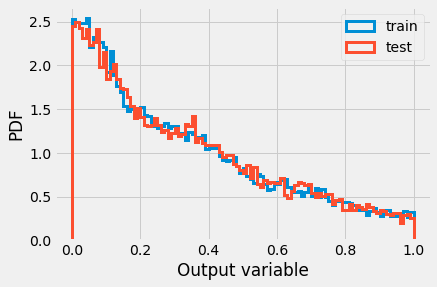

In [4]:
# check the PDF of the training and test samples for the output variable
bins = np.linspace(0.,1.,101)
plt.xlabel( "Output variable" )
plt.ylabel( "PDF" )
discard = plt.hist( y_train, bins=bins, density=True, histtype='step', lw=3, label="train" )
discard = plt.hist( y_test, bins=bins, density=True, histtype='step', lw=3, label="test" )
plt.legend()

## 3. Systematic hyperparameter tuning  

The hyperparameters we need to set include:

- `loss`: a loss function to be minimized. We will use 'ls', which is basically MSE.
- `max_depth`: the maximum depth limits the number of nodes in the trees; its best value depends on the interaction of the input variables; we will start with 10 and can tune it later.
- `learning_rate`: learning rate shrinks the contribution of each tree; there is a trade-off between learning rate and boosting steps; we will use 0.02 and, for simplicity, keep it constant. When searching for the optimal hyperparameter values, we will use a 5 times higher learning rate to speed up the search.
- `min_samples_split`: the minimum number of samples required to split an internal node; we will start with 50 and can tune it later.
- `max_features`: the number of features to consider when looking for the best split; we will use the number of features in the data.
- `subsample`: the fraction of samples to be used for fitting the individual trees; if smaller than 1.0, this results in Stochastic Gradient Boosting. We will use 0.9.
- `n_estimators`: the number of boosting steps or decision trees.


### Step 1: Optimize `n_estimators` using high learning rate, `learning_rate=0.1`

In [6]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV

# candidates
param_test_n_est = {'n_estimators': range(40, 100, 10)}

# create the regressor
gbr_n_est = GradientBoostingRegressor(loss='ls', learning_rate=0.1, 
                                      max_features=num_features, max_depth=10,
                                      min_samples_split=50, subsample=0.9,
                                      random_state=0)

# define hyperparameter search
gsearch = GridSearchCV(estimator= gbr_n_est, param_grid = param_test_n_est, 
                       scoring='neg_mean_squared_error', cv=5, verbose=3)

# perform search
gsearch.fit( x_train, y_train.flatten() )


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................................n_estimators=40; total time=   5.2s
[CV 2/5] END ................................n_estimators=40; total time=   5.0s
[CV 3/5] END ................................n_estimators=40; total time=   5.2s
[CV 4/5] END ................................n_estimators=40; total time=   6.0s
[CV 5/5] END ................................n_estimators=40; total time=   6.0s
[CV 1/5] END ................................n_estimators=50; total time=   7.7s
[CV 2/5] END ................................n_estimators=50; total time=   7.4s
[CV 3/5] END ................................n_estimators=50; total time=   8.6s
[CV 4/5] END ................................n_estimators=50; total time=   7.1s
[CV 5/5] END ................................n_estimators=50; total time=   9.0s
[CV 1/5] END ................................n_estimators=60; total time=  11.7s
[CV 2/5] END ................................n_es

GridSearchCV(cv=5,
             estimator=GradientBoostingRegressor(max_depth=10, max_features=10,
                                                 min_samples_split=50,
                                                 random_state=0,
                                                 subsample=0.9),
             param_grid={'n_estimators': range(40, 100, 10)},
             scoring='neg_mean_squared_error', verbose=3)

In [7]:
# print best n_estimators
print( gsearch.best_params_ )
best_n_estimators = gsearch.best_params_['n_estimators']
print( "Best 'n_estimators' parameter:", best_n_estimators )

{'n_estimators': 50}
Best 'n_estimators' parameter: 50


### Step 2: Optimize tree parameters, `max_depth` and `min_samples_split`, with best `n_estimators`

In [13]:
# candidates
param_test_tree = {'max_depth': range(5, 16, 2), 
                   'min_samples_split': range(10, 100, 20) }

# create the regressor
gbr_tree = GradientBoostingRegressor(loss='ls', learning_rate=0.1, 
                                     max_features=num_features, subsample=0.9,
                                     n_estimators=best_n_estimators, random_state=0)

# define hyperparameter search
gsearch = GridSearchCV(estimator= gbr_tree, param_grid = param_test_tree, 
                       scoring='neg_mean_squared_error', cv=5, verbose=3)

# perform search
gsearch.fit( x_train, y_train.flatten() )

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END ..............max_depth=5, min_samples_split=10; total time=   4.3s
[CV 2/5] END ..............max_depth=5, min_samples_split=10; total time=   4.6s
[CV 3/5] END ..............max_depth=5, min_samples_split=10; total time=   4.2s
[CV 4/5] END ..............max_depth=5, min_samples_split=10; total time=   5.1s
[CV 5/5] END ..............max_depth=5, min_samples_split=10; total time=   5.2s
[CV 1/5] END ..............max_depth=5, min_samples_split=30; total time=   4.4s
[CV 2/5] END ..............max_depth=5, min_samples_split=30; total time=   3.9s
[CV 3/5] END ..............max_depth=5, min_samples_split=30; total time=   3.9s
[CV 4/5] END ..............max_depth=5, min_samples_split=30; total time=   3.9s
[CV 5/5] END ..............max_depth=5, min_samples_split=30; total time=   4.3s
[CV 1/5] END ..............max_depth=5, min_samples_split=50; total time=   5.4s
[CV 2/5] END ..............max_depth=5, min_sam

GridSearchCV(cv=5,
             estimator=GradientBoostingRegressor(max_features=10,
                                                 n_estimators=50,
                                                 random_state=0,
                                                 subsample=0.9),
             param_grid={'max_depth': range(5, 16, 2),
                         'min_samples_split': range(10, 100, 20)},
             scoring='neg_mean_squared_error', verbose=3)

In [15]:
print( gsearch.best_params_ )
best_max_depth = gsearch.best_params_['max_depth']
best_min_samples_split = gsearch.best_params_['min_samples_split']

{'max_depth': 7, 'min_samples_split': 90}


### Step 3: Lower `learning_rate` and increase `n_estimators`  

Here we use a factor of 5, so `learning_rate` is lowered to 0.02 and `n_estimators` is increased to 250.  

Also, cross-validation (CV) means using a smaller training set than the full one, so will underpredict the number of estimators that minimize the generalization error. To account for this effect, we further multiply `n_estimators` by 2.

In [30]:
factor = 5
learning_rate = 0.1 / factor
n_estimators = int(best_n_estimators * factor * 2)

# create the "optimised" regressor
gbr = GradientBoostingRegressor(loss='ls', learning_rate=learning_rate, 
                                max_features=num_features, subsample=0.9,
                                n_estimators=n_estimators, random_state=0,
                                max_depth=best_max_depth, min_samples_split=best_min_samples_split,
                                verbose=1 )

# fit the training data
gbr.fit( x_train, y_train.flatten() )

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0648           0.0020            1.25m
         2           0.0628           0.0019            1.14m
         3           0.0610           0.0018            1.06m
         4           0.0593           0.0017            1.01m
         5           0.0579           0.0016            1.05m
         6           0.0562           0.0015            1.02m
         7           0.0548           0.0014           59.76s
         8           0.0530           0.0015           59.40s
         9           0.0517           0.0014           59.03s
        10           0.0501           0.0014           58.43s
        20           0.0392           0.0009            1.09m
        30           0.0314           0.0006            1.12m
        40           0.0260           0.0004            1.12m
        50           0.0222           0.0003            1.06m
        60           0.0196           0.0002            1.02m
       

GradientBoostingRegressor(learning_rate=0.02, max_depth=7, max_features=10,
                          min_samples_split=90, n_estimators=500,
                          random_state=0, subsample=0.9, verbose=1)

## Plot the learning curve of the model

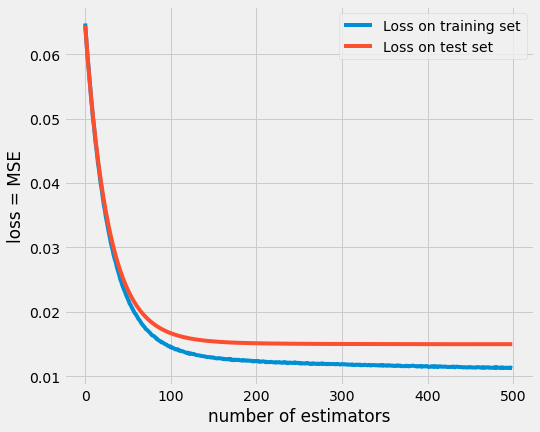

In [42]:
from sklearn.metrics import mean_squared_error

test_score = np.zeros( (n_estimators,), dtype=np.float64 )
staged_predict = gbr.staged_predict(x_test)
for i in range(n_estimators):
    test_score[i] = mean_squared_error( y_test, next(staged_predict) )


# plot the scores
fig1 = plt.figure( figsize=(1*7.5,1*6.5) )
plt.xlabel( "number of estimators" )
plt.ylabel( "loss = MSE" )

train_curve, = plt.plot(gbr.train_score_, label='Loss on training set')
test_curve,  = plt.plot(test_score, label='Loss on test set')
plt.legend()
plt.show()

The loss of the test set approaches a constant value and seems to change little for number of estimators above 200.  

Is this really the case? Or is it an artifact of the large range covered by the y-axis due to large losses at the start of the training.  

We can further inspect this by zooming on the test set loss function for number of estimators > 200.

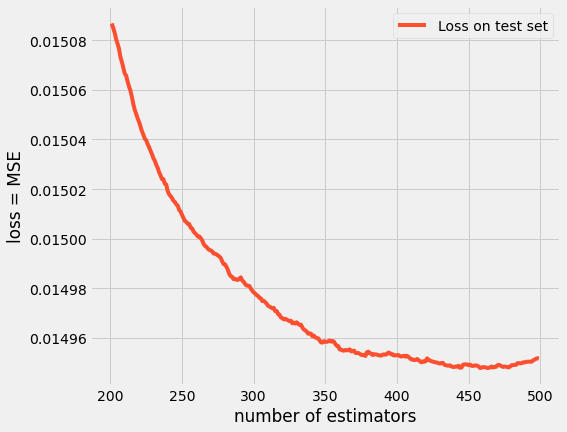

In [43]:
fig1 = plt.figure( figsize=(1*7.5,1*6.5) )
plt.xlabel( "number of estimators" )
plt.ylabel( "loss = MSE" )

sel = np.arange(n_estimators)>200  # select only points for number estimators > 200
plt.plot( np.arange(n_estimators)[sel], test_score[sel], c=test_curve.get_color(), label='Loss on test set' )
plt.legend()

So the loss for the test set keeps decreasing for up to around 470 estimators, after which increases slowly indicating mild overfitting.  

The decrease after 200 estimators is very low indicating only a marginal increase in prediction accuracy.

In [73]:
# calculate the predictions
pred_y_test = gbr.predict(x_test)

# save the test set predictions to a file
outfile = "data_output/GBR/pred_y_test_full_model.npz"
np.savez_compressed( outfile, pred_y_test=pred_y_test )

## Load the kNN predictions and compare against the GBR predictions 


In [60]:
with np.load( "data_output/kNN/pred_y_test_full_model.npz" ) as data:
    pred_y_test_kNN = data["pred_y_test"][:,0]


In [50]:
MSE = test_score[-1]  # MSE of the GBR predcition
MSE_kNN = mean_squared_error( y_test, pred_y_test_kNN )

print("MSE for GBR prediction:    %.5f" % MSE)
print("MSE for kNN prediction:    %.5f" % MSE_kNN)
print("Difference MSE kNN - GBR:  %.5f  (%.1f %%)" % (MSE_kNN-MSE, (MSE_kNN-MSE)*100./MSE) )

MSE for GBR prediction:    0.01495
MSE for kNN prediction:    0.01556
Difference MSE kNN - GBR:  0.00061  (4.1 %)


The more complex GBR method leads only to a modest increase in prediction accuracy of only 4%. 

## Compare the PDF of the true output and predicted values  

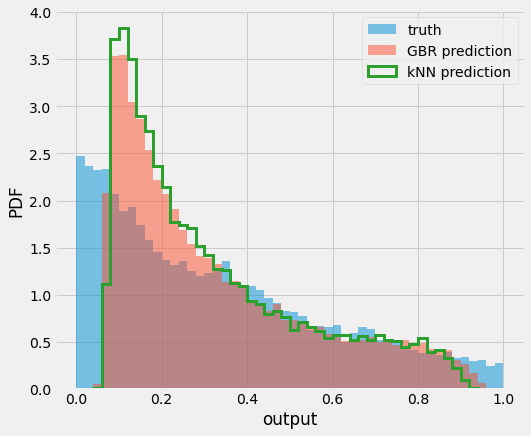

In [49]:
bins = np.linspace(0.,1.,51)

fig1 = plt.figure( figsize=(1*7.5,1*6.5) )
plt.xlabel( "output" )
plt.ylabel( "PDF" )

plt.hist( y_test, bins=bins, density=True, alpha=0.5, label="truth")
plt.hist( pred_y_test, bins=bins, density=True, alpha=0.5, label="GBR prediction")
plt.hist( pred_y_test_kNN, bins=bins, density=True, histtype='step', lw=3, color=colors[2], label="kNN prediction")
plt.legend()

As expected, we find that the ML cannot fully reproduce the output PDF, failing to obtain the values in the tails of the distribution. This is to be expected since **it is the tendency of ML to make predictions towards the mean value.**

Compared to kNN, the PDF of the GBR prediction is slightly wider and a bit closer to the true PDF **indicating that GBR indeed leads to better predictions.** However the differences between GBR and kNN the PDF are minor, in line with the observation that the GBR loss is only 4% lower than the kNN one. 

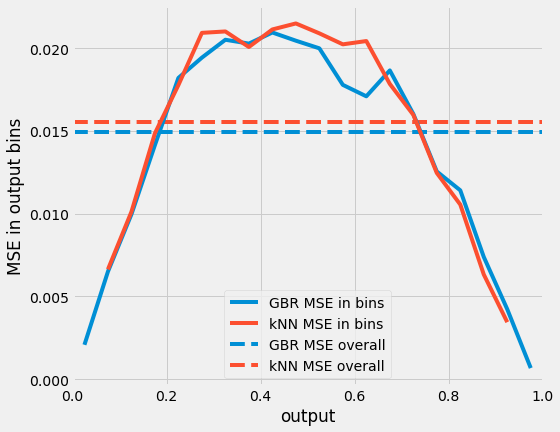

In [63]:
def running_mean(x, y, x_bins):
    """Calculates the mean y in bins of x."""
    mean = []
    for i in range( len(x_bins)-1 ):
        sel = (x>x_bins[i]) * (x<=x_bins[i+1])
        if sel.sum()>10: mean.append( y[sel].mean() )  # when enough point inside the bin
        else: mean.append( 0 )
    return np.array(mean)


SE = (pred_y_test - y_test.flatten())**2
SE_kNN = (pred_y_test_kNN - y_test.flatten())**2

fig1 = plt.figure( figsize=(1*7.5,1*6.5) )
plt.xlabel( "output" )
plt.ylabel( "MSE in output bins" )

# calculate the error as a function of target value
target_bins = np.linspace( 0., 1., 21 )
target_vals = 0.5 * (target_bins[1:] + target_bins[:-1])
MSE_bins    = running_mean( pred_y_test, SE, target_bins )
MSE_bins_kNN= running_mean( pred_y_test_kNN, SE_kNN, target_bins )

plt.xlim( [0.,1.])
valid = MSE_bins > 0.
line, = plt.plot( target_vals[valid], MSE_bins[valid], label="GBR MSE in bins" )
plt.hlines( MSE, 0., 1., ls='--', color=line.get_color(), label="GBR MSE overall" )

valid = MSE_bins_kNN > 0.
line, = plt.plot( target_vals[valid], MSE_bins_kNN[valid], label="kNN MSE in bins" )
plt.hlines( MSE_kNN, 0., 1., ls='--', color=line.get_color(), label="kNN MSE overall" )
plt.legend()

## Calculate which features dominate the prediction

In [64]:
from sklearn.inspection import permutation_importance

Nmax = 5000  # use a subset of the test set to speed up the calculation
perm_imp = permutation_importance( gbr, x_test[:Nmax], y_test[:Nmax], n_repeats=5, random_state=0, \
                                  scoring='neg_mean_squared_error' )

In [78]:
# save the permutation importance to a file
outfile = "data_output/GBR/permutation_importance_test_full_model.npz"
np.savez_compressed( outfile, importances_mean=perm_imp.importances_mean, importances_std=perm_imp.importances_std, \
                   importances=perm_imp.importances)

In [79]:
# load the kNN permutation importance
with np.load("data_output/kNN/permutation_importance_test_full_model.npz") as data:
    importances_mean_kNN = data["importances_mean"]

List of feature indexes sorted by importance:  [1 7 6 0 2 3 4 8 9 5]
List of feature names   sorted by importance:  ['N_sat 1.e6' 'vel. radial' 'vel. tan.' 'M_star' 'N_sat 1.e7' 'N_sat 1.e8'
 'N_sat 1.e9' 'mean L' 'mean d' 'N_sat 1.e10']


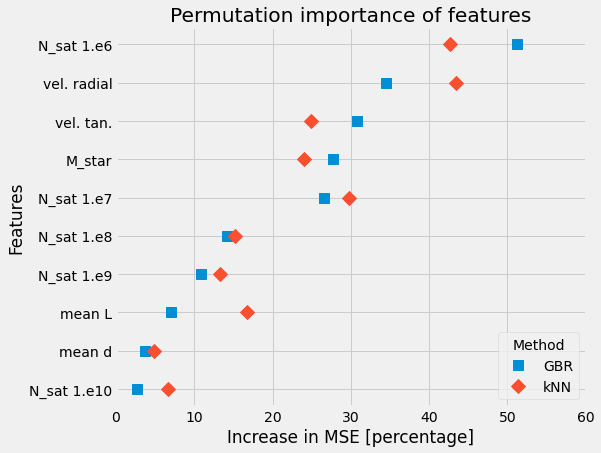

In [82]:
# order of feature importance
perm_sorted_idx = perm_imp.importances_mean.argsort()
print( "List of feature indexes sorted by importance: ", perm_sorted_idx[::-1] )
print( "List of feature names   sorted by importance: ", name_input[perm_sorted_idx][::-1] )

fig1 = plt.figure( figsize=(1*7.5,1*6.5) )
plt.title( "Permutation importance of features" )
plt.ylabel( "Features" )
plt.xlabel( "Increase in MSE [percentage]" )
plt.xlim( [0,60] )
plt.yticks( np.arange(10), name_input[perm_sorted_idx] )

plt.plot( perm_imp.importances_mean[perm_sorted_idx].T*100./MSE, np.arange(10), 's', ms=10, label="GBR" )
plt.plot( importances_mean_kNN[perm_sorted_idx].T*100./MSE_kNN, np.arange(10), 'D', ms=10, label="kNN" )
plt.legend( loc=4, title="Method" )

We find differences in the permutation importance of features in GBR vs. kNN. These differences are somewhat larger than the 4% improvement in MSE between GBR and kNN indicating that even a small improvement in model accuracy can lead to considerable changes in the importances of features.  

## Compare the feature importance when removing the high multicollinearity features  

In this case, there is only one high multicollinearity feature: feature 9 = 'mean L'.  

Normally we would need to calculate the optimal values of the hyperparameters again, but for simplicity and since we only remove 1 out of 10 features, we can as well use the previous optimal values.

In [84]:
sel = np.ones( num_features, bool )
sel[8] = False
print( "Reruning the GBR pipeline after removing the features:", name_input[~sel] )

# define the new features after removing the high multicollinearity features 
# noMC = no multicollinearity
name_input_noMC = name_input[sel]
x_train_noMC = x_train[:,sel]
x_test_noMC  = x_test[:,sel]

gbr_noMC = GradientBoostingRegressor(loss='ls', learning_rate=learning_rate, 
                                max_features=num_features-1, subsample=0.9,
                                n_estimators=n_estimators, random_state=0,
                                max_depth=best_max_depth, min_samples_split=best_min_samples_split,
                                verbose=1 )
gbr_noMC.fit( x_train_noMC, y_train.flatten() )

MSE_noMC = mean_squared_error( gbr_noMC.predict( x_test_noMC ), y_test.flatten() )

print( "MSE no high MC features: \t%.5f" % MSE_noMC )
print( "MSE full       features: \t%.5f" % MSE )
print( "Increase in MSE:         \t%.5f (%.1f %%)" % (MSE_noMC-MSE, (MSE_noMC-MSE)*100./MSE) )

Reruning the GBR pipeline after removing the features: ['mean L']
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0648           0.0020            1.62m
         2           0.0628           0.0019            1.20m
         3           0.0610           0.0018            1.02m
         4           0.0593           0.0017           56.00s
         5           0.0579           0.0016           53.80s
         6           0.0562           0.0016           52.14s
         7           0.0548           0.0014           50.43s
         8           0.0531           0.0015           50.33s
         9           0.0518           0.0014           49.78s
        10           0.0502           0.0014           49.21s
        20           0.0393           0.0009           45.70s
        30           0.0315           0.0006           44.26s
        40           0.0262           0.0004           43.36s
        50           0.0223           0.0003           42.44s
   

In [85]:
perm_imp_noMC = permutation_importance( gbr_noMC, x_test_noMC[:Nmax], y_test[:Nmax], n_repeats=5, random_state=0, \
                                  scoring='neg_mean_squared_error' )

List of feature indexes sorted by importance:  [1 6 7 0 2 3 4 8 5]
List of feature names   sorted by importance:  ['N_sat 1.e6' 'vel. tan.' 'vel. radial' 'M_star' 'N_sat 1.e7' 'N_sat 1.e8'
 'N_sat 1.e9' 'mean d' 'N_sat 1.e10']


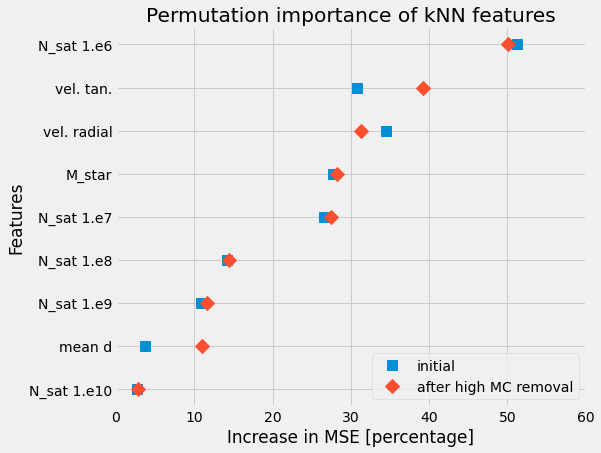

In [89]:
# order of feature importance for the no multicollinearity case
perm_sorted_idx_noMC = perm_imp_noMC.importances_mean.argsort()
print( "List of feature indexes sorted by importance: ", perm_sorted_idx_noMC[::-1] )
print( "List of feature names   sorted by importance: ", name_input_noMC[perm_sorted_idx_noMC][::-1] )

fig1 = plt.figure( figsize=(1*7.5,1*6.5) )
plt.title( "Permutation importance of kNN features" )
plt.ylabel( "Features" )
plt.xlabel( "Increase in MSE [percentage]" )
plt.xlim( [0,60] )
plt.yticks( np.arange(9), name_input_noMC[perm_sorted_idx_noMC] )

plt.plot( perm_imp.importances_mean[sel][perm_sorted_idx_noMC].T*100./MSE, np.arange(9), 's', ms=10, label="initial" )
plt.plot( perm_imp_noMC.importances_mean[perm_sorted_idx_noMC].T*100./MSE_noMC, np.arange(9), 'D', ms=10, \
         label="after high MC removal" )
plt.legend(loc=4)
